# Reproduce: Quantum electrodynamics near a photonic bandgap (Preliminary)

Yanbing Liu and Andrew A Houck, Quantum electrodynamics near a photonic bandgap, Nat. Phys., (2016).

Reproduced by <strong>Eunjong Kim</strong> (eunjongkim@caltech.edu)

## Symbolic Calculation of the transfer matrix and eigenequation

In this section, we derive the equation (1) of 

In [1]:
import sympy as sp
sp.init_printing()

In [2]:
# Define symbolic variables corresponding to frequency,
# wavevector, and size of the unit cell
omega = sp.Symbol(r'\omega')
k = sp.Symbol(r'k')
d = sp.Symbol(r'd')

In [3]:
# Number of sections in a unit cell
M = 2

# Define a list of phase velocity, characteristic impedance,
# and length of each section of the unit cell
v = []; Z = []; l = [];
for idx in range(M):
    v.append(sp.Symbol(r'v_{s%d}' % idx))
    Z.append(sp.Symbol(r'Z_{s%d}' % idx))
    l.append(sp.Symbol(r'l_{s%d}' % idx))

In [4]:
def CPW_ABCD(omega, idx):
    """
    Construct an ABCD matrix (symbolic) of the coplanar waveguide of specified index
    """
    A = sp.cos(omega * l[idx] / v[idx])
    B = sp.I * sp.sin(omega * l[idx] / v[idx]) * Z[idx]
    C = sp.I * sp.sin(omega * l[idx] / v[idx]) / Z[idx]
    D = sp.cos(omega * l[idx] / v[idx])
    return sp.Matrix([[A, B], [C, D]])

#def qubit_ABCD(omega):
#    A = 1
#    B = 0
#    C = - sp.I * gamma / (omega-omega_a) / Z0
#    D = 
#    return sp.Matrix([[A, B], [C, D]])

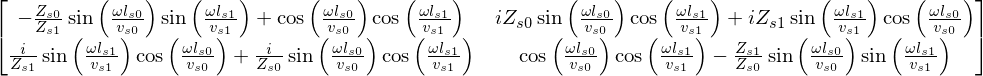

In [5]:
M = CPW_ABCD(omega, 0) * CPW_ABCD(omega, 1)
M

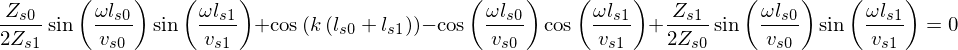

In [6]:
Expr = sp.simplify(sp.det(M * sp.exp(sp.I*k*d) - sp.eye(2))/(2 * sp.exp(sp.I*k*d))).subs(d, sum(l))
sp.Eq(Expr, 0)

Equation (1) is obtained.

In [7]:
#def ABCDtoS(M, Z0):
#    [[A, B], [C, D]] = M
#    S11 = 
#    S12 = 
#    S21 = 
#    S22 = 


In [8]:
import numpy as np
import numpy.linalg as la
from scipy.optimize import brentq
from scipy.integrate import quad

The eigenfrequency is given by $\omega_0 /2\pi= 7.79\textrm{ GHz}$

In [9]:
omega0 = 2 * np.pi * 7.7e9

In [10]:
l0, l1 = 0.45e-3, 8e-3
Z0, Z1 = 28, 125
d = l0 + l1
v_p = omega0 * d / np.pi

In [11]:
expr = Expr.subs({l[0]: l0, l[1]: l1,
                  Z[0]: Z0, Z[1]: Z1,
                  v[0]: v_p, v[1]: v_p})

In [12]:
func = sp.lambdify((omega, k), expr, "numpy")

In [13]:
N_kPts = 100
N_band = 4

d = 0.45e-3 + 8e-3
kPts = np.linspace(- np.pi / d, np.pi / d, N_kPts)

In [14]:
freq = np.zeros((N_band, N_kPts))

for n in range(N_band):
    for idx, k_ in enumerate(kPts):
        # search for eigenfrequency between n\omega_0 and (n+1)\omega_0
        freq[n, idx] = brentq(func, n * omega0, (n+1) * omega0, args=(k_)) / (2 * np.pi)

In [15]:
# setup for plots
import matplotlib.pyplot as plt
from matplotlib import rcParams, cm
%matplotlib inline
rcParams.update({"text.usetex": True, "font.size": 16})

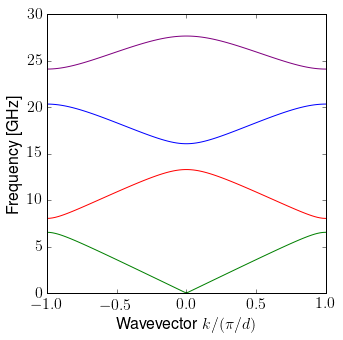

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
fig_colors = ['green','red','blue', 'purple']
for n in range(N_band):
    ax.plot(kPts / (np.pi / d), freq[n, :] / 1e9, color=fig_colors[n])

ax.set_xlabel(r'Wavevector $k/(\pi/d)$');
ax.set_ylabel('Frequency [GHz]');

### PDE Solving using the discretization

To analyze the mode structure (Bloch wavefunction) of an infinite microwave photonic crystal, we solve the following series of differential equations

$$
\frac{\partial}{\partial x} V(x, t) = -l(x) \frac{\partial}{\partial t} I(x,t), \quad \frac{\partial}{\partial x} I(x, t) = -c(x) \frac{\partial}{\partial t} V(x,t)
$$

which reduces to a single partial differential equation of $V(x, t)$

$$
\frac{\partial}{\partial x} \left[ \frac{v_p}{Z_c(x)} \frac{\partial V(x,t)}{\partial x}\right]
= \frac{1}{v_p Z_c(x)} \frac{\partial^2}{\partial t^2} V(x,t)
$$

The characteristic impedance $Z_c(x) = \sqrt{l(x)/c(x)}$ inside the unit cell ($-d/2< x < d/2$) is let to be
$$
Z_c (x) = 
$$
while the phase velocity $v_p = 1/\sqrt{l(x)c(x)}$ is a constant.

The time-independent ODE is obtained by separation of variables $V(x, t) = V(x) e^{i\omega t}$
$$
\frac{d}{dx} \left[\frac{1}{Z_c(x)} \frac{dV(x)}{dx}\right] = - \left(\frac{\omega}{v_p}\right)^2 \frac{V(x)}{Z_c(x)}
$$

We solve the partial differential equation




For numerical calculation of the mode structure, we impose the periodic boundary condition $Z_c(x) = Z_c(x+d)$ Fourier series expand $1/Z_c(x)$ as
$$
\frac{1}{Z_c (x)} = \sum_{m} \eta_{m} e^{i2\pi m x/d}.
$$

Here the Fourier coefficients $\eta_m$ are written as
$$\eta_m = \frac{1}{d} \int_{-d/2}^{d/2} dx \frac{e^{-i 2\pi m x/d}}{Z_c(x)}$$

In [17]:
# Characteristic impedance inside the unit cell
def Zc(x):
    return Z1 * ((x > -l1/2) * (x < l1/2)) \
           + Z0 * ((x < -l1/2) + (x > l1/2))

def eta(n_):
    """
    The n-th discrete Fourier coefficient of 1/Zc(x).
    Imaginary part vanishes due to the even parity of Zc(x)
    with respect to the x = 0 plane.
    """
    integrand = lambda x: (1 / Zc(x) * np.exp(-2j*np.pi*n_*x/d))
    return quad(integrand, -d/2, d/2)[0] / d

In [18]:
N_xPts = 100
xPts = np.linspace(-d/2, d/2, N_xPts)

In [19]:
# discrete Fourier space dimension
L = 10
n = np.arange(- 2 * L, 2 * L + 1)
eta_array = np.zeros(4 * L + 1)
for n_ in n:
    eta_array[n_ + 2 * L] = eta(n_)

/opt/local/Library/Frameworks/Python.framework/Versions/3.4/lib/python3.4/site-packages/scipy/integrate/quadpack.py:380: ComplexWarning: Casting complex values to real discards the imaginary part
  return _quadpack._qagse(func,a,b,args,full_output,epsabs,epsrel,limit)


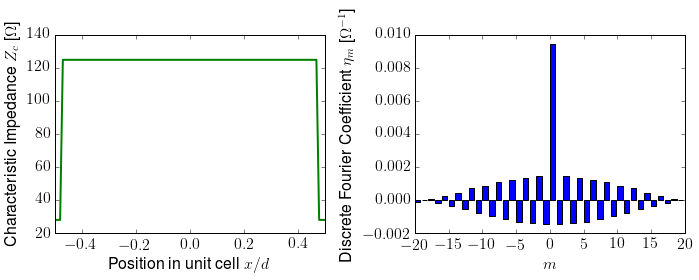

In [20]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

axes[0].plot(xPts/d, Zc(xPts), color=fig_colors[0], lw=2)
axes[0].set_xlabel('Position in unit cell $x/d$')
axes[0].set_ylabel(r'Characteristic Impedance $Z_c$   [$\Omega$]')
axes[0].set_xlim([-1/2, 1/2]);

axes[1].bar(n, eta_array, color=fig_colors[2]);
axes[1].set_xlabel(r'$m$')
axes[1].set_xlim([-2*L, 2*L]);
axes[1].set_ylabel(r'Discrete Fourier Coefficient $\eta_m$  [$\Omega^{-1}$]')
fig.tight_layout();

To solve this differential equation, we introduce eigenfunctions of the Bloch form $V_k(x) = u_k(x) e^{ikx}$ which satisfies $u_k(x+d) = u_k(x)$ and thus can be Fourier series expanded as
$$ u_k(x) = \sum_{m} c_{k,m} e^{i2\pi m x/d}$$

$$
\frac{d}{dx} \left[\sum_{m} \eta_{m} e^{i2\pi m x/d} \frac{d}{dx}\sum_{m'} c_{k,m'} e^{i(k+2\pi m' /d)x}\right] = - \left(\frac{\omega}{v_p}\right)^2 \sum_{m} \eta_{m} e^{i2\pi m x/d}\sum_{m'} c_{k,m'} e^{i(k+2\pi m' /d)x}
$$

$$
\frac{d}{dx} \left[\sum_{m,m'} \eta_{m} i\left(k+\frac{2\pi m'}{d}\right)c_{k,m'} e^{i[k+2\pi (m+m') /d]x}\right] = - \left(\frac{\omega}{v_p}\right)^2 \sum_{m,m'} \eta_{m} c_{k,m'} e^{i[k+2\pi (m+m') /d)]x}
$$

$$
\sum_{m,m'} \eta_{m} i\left(k+\frac{2\pi m'}{d}\right)i\left(k+\frac{2\pi (m+m')}{d}\right) c_{k,m'} e^{i[k+2\pi (m+m') /d]x} = - \left(\frac{\omega}{v_p}\right)^2 \sum_{m,m'} \eta_{m} c_{k,m'} e^{i[k+2\pi (m+m') /d)]x}
$$

We introduce a new index $n$ to replace $m = n-m'$
$$
-\sum_{m', n} \eta_{n-m'} \left(k+\frac{2\pi m'}{d}\right)\left(k+\frac{2\pi n}{d}\right) c_{k,m'} e^{i(k+2\pi n /d)x} = - \left(\frac{\omega}{v_p}\right)^2 \sum_{m',n} \eta_{n-m'} c_{k,m'} e^{i(k+ 2\pi n /d)x}
$$

Applying the inverse Fourier transform $\frac{1}{d}\int_{-d/2}^{d/2} dx \ e^{-i(k+2\pi m/d)x}$,
$$
-\sum_{m', n} \eta_{n-m'} \left(k+\frac{2\pi m'}{d}\right)\left(k+\frac{2\pi n}{d}\right) c_{k,m'}\left[ \frac{1}{d}\int_{-d/2}^{d/2}dx\ e^{i2\pi (n-m)x /d }\right] = - \left(\frac{\omega}{v_p}\right)^2 \sum_{m',n} \eta_{n-m'} c_{k,m'}\left[ \frac{1}{d}\int_{-d/2}^{d/2}dx\ e^{i2\pi (n-m)x /d }\right]
$$

The delta function identity
$$
\frac{1}{d}\int_{-d/2}^{d/2} dx\ e^{i2\pi (n-m)x /d} = \delta_{n,m}
$$
reduces the equation into a summation only in one index $m'$
$$
\sum_{m'} \eta_{m-m'} \left(k + \frac{2\pi m}{d}\right)\left(k + \frac{2\pi m'}{d}\right) c_{k, m'}
=  \left(\frac{\omega}{v_p}\right)^2 \sum_{m'} \eta_{m-m'} c_{k,m'}
$$

By identifying the matrices $\mathbf{A}$, $\mathbf{B}$, and $\mathbf{c}$ as

$$[\mathbf{A}]_{m, m'} = \eta_{m-m'},\quad
[\mathbf{B}]_{m, m'} = \eta_{m-m'} \left(k + \frac{2\pi m}{d}\right) \left(k + \frac{2\pi m'}{d}\right),\quad
[\mathbf{c}]_m' = c_{k, m'},$$

This is a matrix equation $\mathbf{B}\mathbf{c} = (\omega/v_p)^2 \mathbf{A}\mathbf{c}$ which can be viewed as an eigenequation
$$(\mathbf{A}^{-1}\mathbf{B})\mathbf{c} = \left(\frac{\omega}{v_p}\right)^2 \mathbf{c}$$

In [21]:
A = np.zeros((2 * L + 1, 2 * L + 1))
for i in range(2 * L + 1):
    for j in range(2 * L + 1):
        m, m_ = i - L, j - L   # index offset
        A[i, j] = eta_array[m - m_ + 2 * L]

def B(k):
    temp = np.zeros((2 * L + 1, 2 * L + 1))
    for i in range(2 * L + 1):
        for j in range(2 * L + 1):
            m, m_ = i - L, j - L   # index offset
            temp[i, j] = (eta_array[m - m_ + 2 * L]
                          * (k + 2 * np.pi * m / d)
                          * (k + 2 * np.pi * m_ / d))
    return temp

def Op(k):
    return np.dot(la.inv(A), B(k))

In [22]:
def solve_eigenequation(k):
    eig_vals, eig_vecs = la.eig(Op(k))
    # sorting eigenvalues and eigenvectors
    idx = eig_vals.argsort()
    eig_vals = eig_vals[idx]
    eig_vecs = eig_vecs[:,idx]
    
    eig_freq = np.sqrt(eig_vals) * v_p / (2*np.pi)
    return eig_freq, eig_vecs

In [23]:
def Bloch_wavefunc(x, c):
    """`1
    Given the amplitudes [c],
    Calculate the Bloch wavefunction

        u_k (x) = sum_{n} c_{k, n} exp(i2\pi n x/d)

    and return its absolute value.
    """
    V = np.zeros(len(x))
    for n in range(2 * L + 1):
        V = V + c[n] * np.exp(2j * np.pi * (n - L) * x / d)
    return abs(V)

In [24]:
X, Y = np.meshgrid(kPts, xPts)

N_modes = 2  # Number of modes to consider
eig_funcs = []
eig_freqs = []
for n in range(N_modes):
    eig_funcs.append(np.zeros((len(kPts), len(xPts))))
    eig_freqs.append(np.zeros(len(kPts)))

In [25]:
for idx, k_ in enumerate(kPts):
    eig_vals, eig_vecs = solve_eigenequation(k_)
    for n in range(N_modes):
        eig_funcs[n][:, idx] = Bloch_wavefunc(xPts, eig_vecs[:, n])
        eig_freqs[n][idx] = eig_vals[n]

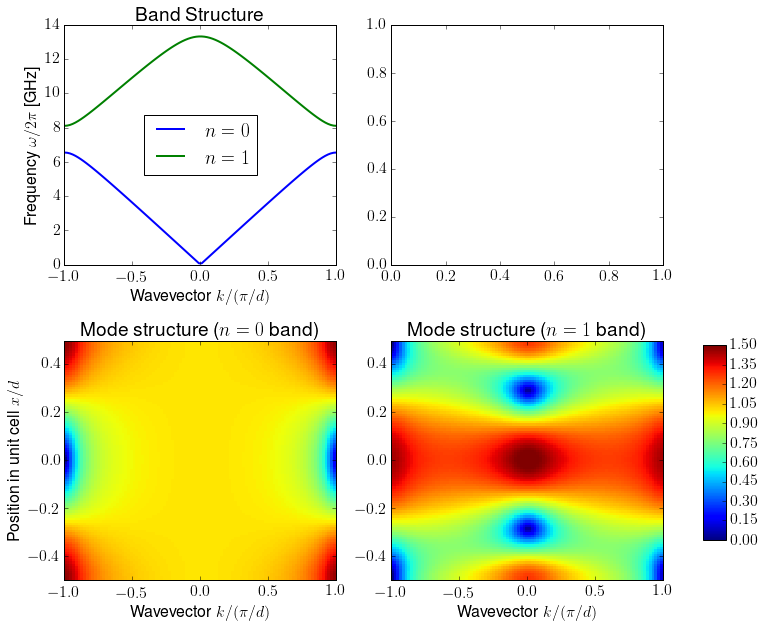

In [26]:
fig, axes = plt.subplots(2, 2, figsize=(11, 9))

# Band structure
for n in range(N_modes):
    axes[0, 0].plot(kPts/(np.pi/d), eig_freqs[n]/1e9, label=r'$n=%d$' % n, lw=2)
axes[0, 0].set_xlabel(r'Wavevector  $k/(\pi/d)$')
axes[0, 0].set_ylabel(r'Frequency $\omega/2\pi$   [GHz]')
axes[0, 0].set_title('Band Structure')
axes[0, 0].legend(loc=0)

# Mode structure
p0 = axes[1, 0].pcolor(X/(np.pi/d), Y/d, eig_funcs[0], cmap=cm.jet, vmin=0, vmax=1.5)
p1 = axes[1, 1].pcolor(X/(np.pi/d), Y/d, eig_funcs[1], cmap=cm.jet, vmin=0, vmax=1.5)
axes[1, 0].set_xlabel(r'Wavevector  $k/(\pi/d)$'); axes[1, 1].set_xlabel(r'Wavevector  $k/(\pi/d)$')
axes[1, 0].set_ylabel(r'Position in unit cell  $x/d$')
axes[1, 0].set_xlim([-1, 1]); axes[1, 1].set_xlim([-1, 1])
axes[1, 0].set_ylim([-0.5, 0.5]); axes[1, 1].set_ylim([-0.5, 0.5])
axes[1, 0].set_title(r'Mode structure ($n=0$ band)')
axes[1, 1].set_title(r'Mode structure ($n=1$ band)');
fig.tight_layout()

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.9, 0.15, 0.03, 0.3])
fig.colorbar(p1, cax=cbar_ax);

## Version Information

In [27]:
%reload_ext version_information

%version_information sympy, numpy, scipy, matplotlib

Software versions
Python 3.4.5 64bit [GCC 4.2.1 Compatible Apple LLVM 7.0.2 (clang-700.1.81)]
IPython 5.0.0
OS Darwin 15.6.0 x86_64 i386 64bit
sympy 1.0
numpy 1.11.1
scipy 0.18.0
matplotlib 1.5.2
Sun Aug 21 20:30:30 2016 PDT